In [1]:
import pandas as pd
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from lib import helper
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
image_size = 331

# training data
train_x = pd.read_csv('train.zip')
train_y = pd.read_csv('train_labels.zip')
x_train = np.array(train_x)[:,1:].reshape((train_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y = np.array(train_y.iloc[:,1])

# validation data
val_x = pd.read_csv('val.zip')
val_y = pd.read_csv('val_labels.zip')


x_val = np.array(val_x)[:,1:].reshape((val_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y_val = np.array(val_y.iloc[:,1])


num_class = max(y) + 1

In [2]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [3]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), labels[indexes]

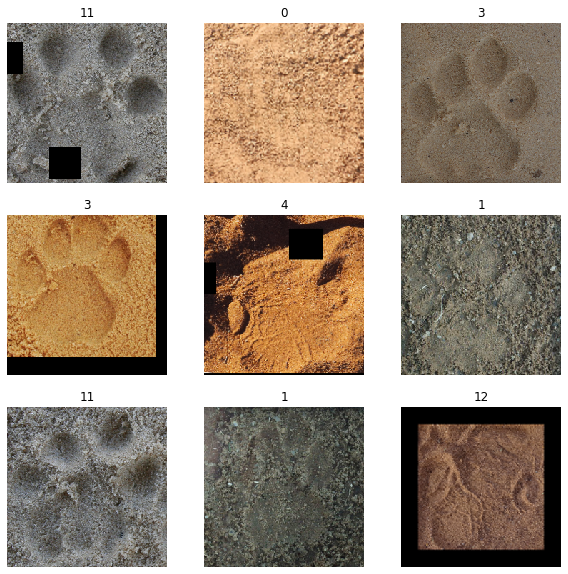

In [6]:


images = generator(x_train,y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(image[1][i])
    plt.axis("off")

In [12]:
image_size = 331
base_model = keras.applications.NASNetLarge(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

343613440/343610240 [==============================] - 4s 0us/step


In [13]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_class)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 13)                52429     
Total params: 84,969,247
Trainable params: 84,772,579
Non-trainable params: 196,668
_________________________________________________________________


In [14]:
# Model optimizer
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
46/45 [==============================] - 95s 2s/step - loss: 2.3812 - accuracy: 0.2143 - val_loss: 2.1049 - val_accuracy: 0.2556 - lr: 5.0000e-04
Epoch 2/100
46/45 [==============================] - 89s 2s/step - loss: 2.0127 - accuracy: 0.3383 - val_loss: 1.7275 - val_accuracy: 0.4861 - lr: 5.0000e-04
Epoch 3/100
46/45 [==============================] - 89s 2s/step - loss: 1.8893 - accuracy: 0.3923 - val_loss: 1.6554 - val_accuracy: 0.4528 - lr: 5.0000e-04
Epoch 4/100
46/45 [==============================] - 89s 2s/step - loss: 1.7985 - accuracy: 0.4270 - val_loss: 1.5263 - val_accuracy: 0.4917 - lr: 5.0000e-04
Epoch 5/100
46/45 [==============================] - 89s 2s/step - loss: 1.7598 - accuracy: 0.4226 - val_loss: 1.4198 - val_accuracy: 0.6139 - lr: 5.0000e-04
Epoch 6/100
46/45 [==============================] - 89s 2s/step - loss: 1.7105 - accuracy: 0.4521 - val_loss: 1.4604 - val_accuracy: 0.5611 - lr: 5.0000e-04
Epoch 7/100
46/45 [==============================] -

In [16]:
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 32
# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
92/91 [==============================] - 333s 4s/step - loss: 2.5497 - accuracy: 0.1515 - val_loss: 2.1463 - val_accuracy: 0.2556 - lr: 1.0000e-04
Epoch 2/200
92/91 [==============================] - 329s 4s/step - loss: 2.0090 - accuracy: 0.3145 - val_loss: 1.7491 - val_accuracy: 0.3639 - lr: 1.0000e-04
Epoch 3/200
92/91 [==============================] - 331s 4s/step - loss: 1.5869 - accuracy: 0.4742 - val_loss: 1.4223 - val_accuracy: 0.5528 - lr: 1.0000e-04
Epoch 4/200
92/91 [==============================] - 330s 4s/step - loss: 1.2116 - accuracy: 0.5846 - val_loss: 1.0806 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 5/200
92/91 [==============================] - 331s 4s/step - loss: 0.9617 - accuracy: 0.6766 - val_loss: 0.7809 - val_accuracy: 0.7139 - lr: 1.0000e-04
Epoch 6/200
92/91 [==============================] - 331s 4s/step - loss: 0.7694 - accuracy: 0.7459 - val_loss: 0.7060 - val_accuracy: 0.7722 - lr: 1.0000e-04
Epoch 7/200
92/91 [===========================

In [17]:
model.save('NASNetLarge.h5')

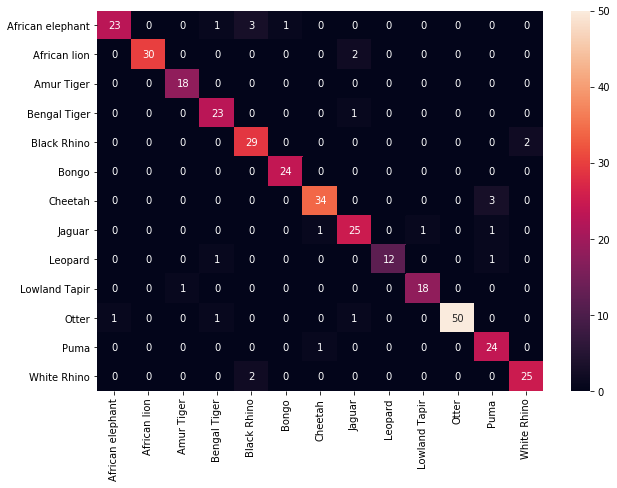

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['African elephant','African lion','Amur Tiger','Bengal Tiger', 'Black Rhino','Bongo' 
          ,'Cheetah','Jaguar','Leopard','Lowland Tapir', 'Otter','Puma','White Rhino']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)